<a href="https://colab.research.google.com/github/YueAlexFu/bank-classification/blob/main/dc_termDeposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Becky - DA training/Data Challenge/04-termDeposit/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Becky - DA training/Data Challenge/04-termDeposit


In [2]:
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
!pip install pyforest

In [4]:
from pyforest import *

In [5]:
df=pd.read_csv('bank-additional-full.csv',index_col=False, delimiter=';')
print(df.shape)
df.head()

<IPython.core.display.Javascript object>

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# demographic
deCol=['age','job','marital','education']
# behaviorial
beCol = ['default','housing','loan','pdays','previous','poutcome']
# info of contact
coCol= ['contact','month','day_of_week','duration','campaign']
# economic enviroment index
enCol=['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
# target variable
target_variable = ['y']

# change the month and day_of_week to numbers
month_num = {'jan':1, 'feb':2,'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'mar':3, 'apr':4,'sep':9}
weekday_num = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
df['month_num']=df.month.agg(lambda x: month_num[x])
df['weekday_num'] = df.day_of_week.agg(lambda x: weekday_num[x])

# Overview

In [7]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
month_num         0
weekday_num       0
dtype: int64

### client info

In [8]:
df.age.min(),df.age.max()

(17, 98)

In [9]:
df.job.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [10]:
df[deCol].describe(include='all')

,age,job,marital,education
count,41188.00000,41188,41188,41188
unique,NaN,12,4,8
top,NaN,admin.,married,university.degree
freq,NaN,10422,24928,12168
mean,40.02406,NaN,NaN,NaN
std,10.42125,NaN,NaN,NaN
min,17.00000,NaN,NaN,NaN
25%,32.00000,NaN,NaN,NaN
50%,38.00000,NaN,NaN,NaN
75%,47.00000,NaN,NaN,NaN


### this contact info

In [11]:
df[coCol].describe(include='all')

,contact,month,day_of_week,duration,campaign
count,41188,41188,41188,41188.000000,41188.000000
unique,2,10,5,NaN,NaN
top,cellular,may,thu,NaN,NaN
freq,26144,13769,8623,NaN,NaN
mean,NaN,NaN,NaN,258.285010,2.567593
std,NaN,NaN,NaN,259.279249,2.770014
min,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,102.000000,1.000000
50%,NaN,NaN,NaN,180.000000,2.000000
75%,NaN,NaN,NaN,319.000000,3.000000


### behavioral info

In [12]:
df[beCol].describe(include='all')

,default,housing,loan,pdays,previous,poutcome
count,41188,41188,41188,41188.000000,41188.000000,41188
unique,3,3,3,NaN,NaN,3
top,no,yes,no,NaN,NaN,nonexistent
freq,32588,21576,33950,NaN,NaN,35563
mean,NaN,NaN,NaN,962.475454,0.172963,NaN
std,NaN,NaN,NaN,186.910907,0.494901,NaN
min,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,999.000000,0.000000,NaN
50%,NaN,NaN,NaN,999.000000,0.000000,NaN
75%,NaN,NaN,NaN,999.000000,0.000000,NaN


In [13]:
# check the level of data
df.campaign.value_counts()[0:5]

1    17642
2    10570
3     5341
4     2651
5     1599
Name: campaign, dtype: int64

In [14]:
df[df.pdays!=999].pdays.describe()

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: pdays, dtype: float64

### Econ idx

In [15]:
df[enCol].describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,1.570960,0.578840,4.628198,1.734447,72.251528
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


### target variable

In [16]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [17]:
# more than one contact for the same client
# if the client say yes, will they be contacted again?
df_yes=df[df.y=='yes']
df_no=df[df.y=='no']

In [18]:
df_yes.shape[0]/df.shape[0]*100

11.265417111780131

In [19]:
df_yes.campaign.value_counts().head()

1    2300
2    1211
3     574
4     249
5     120
Name: campaign, dtype: int64

In [20]:
df_no.campaign.value_counts().head()

1    15342
2     9359
3     4767
4     2402
5     1479
Name: campaign, dtype: int64

# Sanity Checking

In [21]:
# demographic
deCol=['age','job','marital','education']
# behaviorial
beCol = ['default','housing','loan','pdays','previous','poutcome']
# info of contact
coCol= ['contact','month','day_of_week','duration','campaign']
# economic enviroment index
enCol=['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
# target variable
target_variable = ['y']

### rule

In [22]:
# check duplicates
df[df.duplicated()].shape, df[df.duplicated()].shape[0]/df.shape[0]*100

((12, 23), 0.02913469942701758)

In [23]:
# fix
df = df.drop_duplicates()

### rule

In [24]:
# pday = 999, poutcome=nonexistent
df[df.pdays==999].groupby(['poutcome','previous'],as_index=False)[['y']].count()

,poutcome,previous,y
0,failure,1,3696
1,failure,2,349
2,failure,3,50
3,failure,4,12
4,failure,5,2
5,failure,6,1
6,nonexistent,0,35551


In [25]:
4110/df.shape[0]*100

9.981542646201671

In [26]:
# fix
df.loc[df.pdays==999,'poutcome'] = 'nonexistent'
df.loc[(df.pdays==999),'previous'] = 0
df[df.pdays==999].groupby(['poutcome','previous'],as_index=False)['y'].count()

,poutcome,previous,y
0,nonexistent,0,39661


### rule

In [27]:
# how many years include? A: three!!
df.groupby(['month_num'],as_index=False)[['emp.var.rate']].nunique()

,month_num,emp.var.rate
0,3,1
1,4,1
2,5,2
3,6,3
4,7,3
5,8,3
6,9,2
7,10,3
8,11,3
9,12,2


### rule

In [28]:
df[(df.campaign==1)&(df.y=='no')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,month_num,weekday_num
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41161,33,admin.,married,university.degree,no,yes,no,cellular,nov,tue,510,1,999,0,nonexistent,-1.1,94.767,-50.8,1.035,4963.6,no,11,2
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,180,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6,no,11,4
41176,38,housemaid,divorced,high.school,no,yes,yes,cellular,nov,thu,360,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6,no,11,4
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,112,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no,11,5


In [29]:
df[(df.campaign==1)&(df.y=='no')].shape[0]/df.shape[0]*100

37.24256848649699

### rule

In [30]:
df.groupby(['default','loan','housing'])[['y']].count()

y
default loan    housing       
no      no      no       12600
                yes      14238
        unknown unknown    763
        yes     no        2008
                yes       2968
unknown no      no        3456
                yes       3641
        unknown unknown    227
        yes     no         549
                yes        723
yes     no      no           2
                yes          1

In [31]:
df.loc[df.duration==0,'y']

6251     no
23031    no
28063    no
33015    no
Name: y, dtype: object

### Summary

In [32]:
df2 = df.copy()

In [33]:
df=pd.read_csv('bank-additional-full.csv',index_col=False, delimiter=';')
print(df.shape)


<IPython.core.display.Javascript object>

(41188, 21)


In [34]:
df2.shape

(41176, 23)

In [35]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [36]:
df2.y.value_counts()

no     36537
yes     4639
Name: y, dtype: int64

In [37]:
df2[df2.y=='yes'].shape[0]/df2.shape[0]

0.11266271614532737

In [38]:
df2.campaign.max()

56

# EDA

## Univariate

### age 

In [39]:
df2.age.describe()

count    41176.00000
mean        40.02380
std         10.42068
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

In [40]:
colors = sns.color_palette("Paired", 2)
colors

<IPython.core.display.Javascript object>

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)]

In [41]:
# sns.distplot(df2.age, hist=True, kde=False,
#              bins=80, color=colors[1],
#              hist_kws={'edgecolor':'black'})
# plt.title('Distribution of Age')
# plt.xlabel('Age')
# plt.ylabel('Count')

In [42]:
def separate_group(x):
    for i in range(1,11):
        if x <= i*10:
            return (i-1)*10
            break
        else:
            continue

In [43]:
df2['age_group'] = [separate_group(x) for x in df2.age]
df2.age_group.value_counts()

30    16380
40    10237
20     7241
50     6269
60      488
70      302
10      140
80      109
90       10
Name: age_group, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

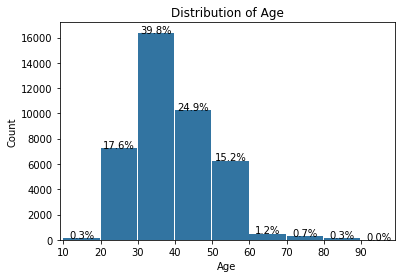

In [44]:
color = sns.color_palette("mako",1)
ax = sns.barplot(x = df2.age_group.value_counts().index, y=df2.age_group.value_counts().values,
                 color=colors[1], )

rects = ax.patches
perc=list()
for patch in ax.patches:
    patch.set_width(0.98)
for rect in rects[0:12]:
    label = round(rect.get_height()/df2.shape[0]*100,1)
    perc.append(label)
    label = str(label)+"%"
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+0.1, label, ha='center')

locs, labels=plt.xticks()
ticks = df2.age_group.value_counts().sort_index().index
plt.xticks(locs-0.4)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')

In [45]:
sum(perc[1:5])

97.5

#### Write up
1. 97.5% of the contacted clients are between 25 to 60.
2. Average age of the clients is 40.
3. 40% clients are between 30-40, while 25% are between 40-50

### job

In [46]:
def cat_plot(col, col_name, title, rotation):
    # get the categories
    cat = df[col].value_counts().index
    # get the counts for the categories
    ct= df[col].value_counts().values

    ax = sns.barplot(x=cat, y=ct, color=colors[1])
    for patch in ax.patches:
        label = round(patch.get_height()/df2.shape[0]*100,1)
        label = str(label)+'%'
        ax.text(patch.get_x()+patch.get_width()/2, patch.get_height()+60, label, ha='center')

    plt.title(title)
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

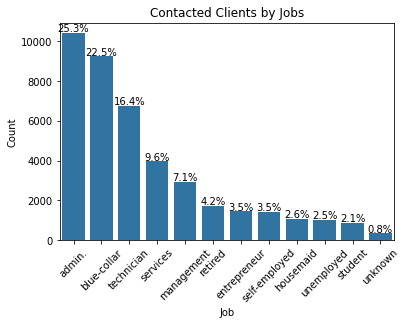

In [47]:
cat_plot('job', 'Job', 'Contacted Clients by Jobs',45)

#### Write up
1. More than 25% of clients work as admin.
2. The top 3 jobs are admin., blue-collar, technician.

In [48]:
# cmap = plt.get_cmap('Spectral')
# colors = [cmap(i) for i in np.linspace(0, 1, 8)]
# plt.pie(x=df2.job.value_counts(),labels=jobs, autopct='%1.1f%%',colors=colors)
# plt.title('Contacted Clients by Jobs')
# plt.xlabel('Types of Job')

### Marital

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

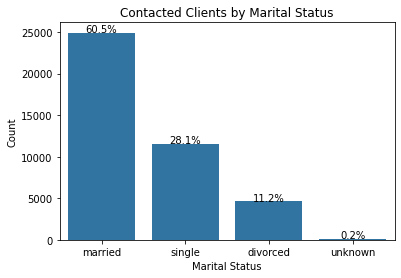

In [49]:
cat_plot('marital', 'Marital Status', 'Contacted Clients by Marital Status',0)

#### Write up
1. 60% clients are married, while 28% are single and 11% are divorced.

### Education

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

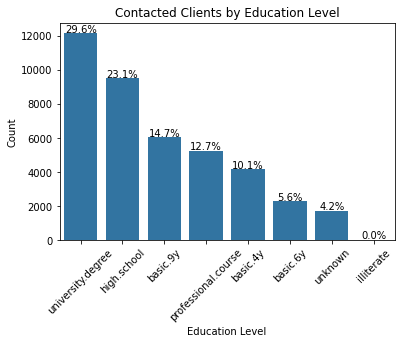

In [50]:
cat_plot('education', 'Education Level', 'Contacted Clients by Education Level',45)

#### Write up
1. .>67% of clients finished basic 9 years education.
2. 30% of clients have university degree.
3. 12% of clients have professional course.

What is professional course?

### Default

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

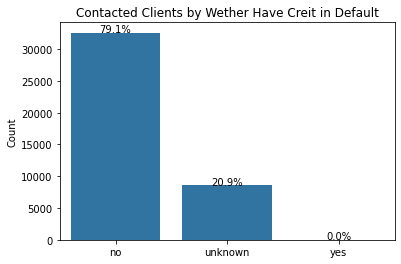

In [51]:
cat_plot('default', '', 'Contacted Clients by Wether Have Creit in Default',0)

### Housing

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

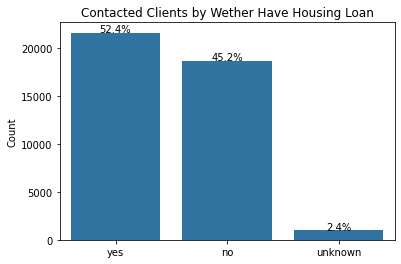

In [52]:
cat_plot('housing', '', 'Contacted Clients by Wether Have Housing Loan',0)

### Loan

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

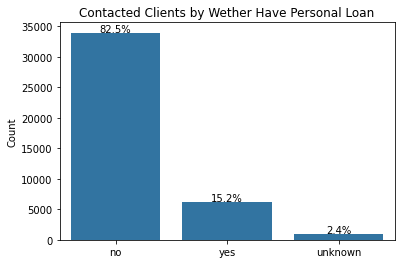

In [53]:
cat_plot('loan', '', 'Contacted Clients by Wether Have Personal Loan',0)

### Contact

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

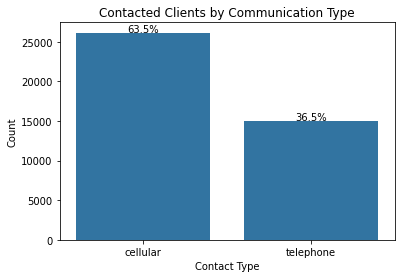

In [54]:
cat_plot('contact', 'Contact Type', 'Contacted Clients by Communication Type',0)

### Month

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

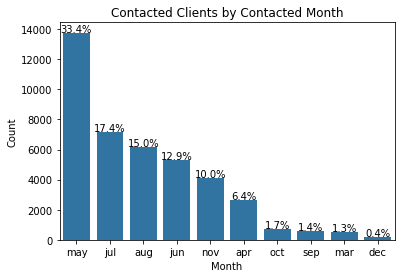

In [55]:
cat_plot('month', 'Month', 'Contacted Clients by Contacted Month',0)

### day of week

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

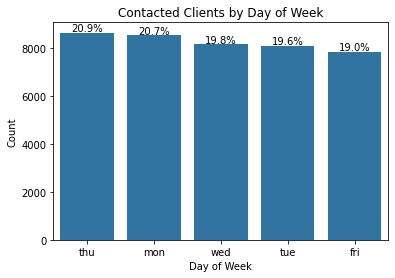

In [56]:
cat_plot('day_of_week', 'Day of Week', 'Contacted Clients by Day of Week',0)

### duration

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Duration')

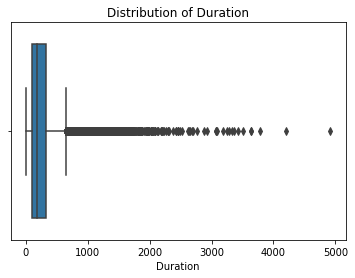

In [57]:
ax = sns.boxplot(x=df2.duration)
plt.title('Distribution of Duration')
plt.xlabel('Duration')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

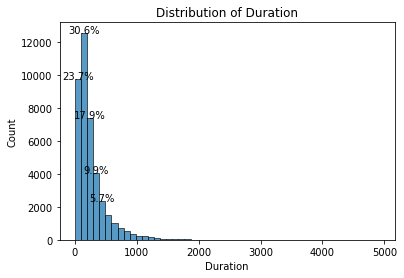

In [58]:
a = df2.duration
ax = sns.histplot(a, bins=50, color=colors[1])

for patch in ax.patches[0:5]:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')


In [59]:
def get_bound(a):
    # https://www.geeksforgeeks.org/finding-the-outlier-points-from-matplotlib/
    # finding the 1st quartile
    q1 = np.quantile(a, 0.25)
    
    # finding the 3rd quartile
    q3 = np.quantile(a, 0.75)
    
    # finding the iqr region
    iqr = q3-q1
    
    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    print(iqr, upper_bound, lower_bound)
    return iqr, upper_bound, lower_bound

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

217.0 644.5 -223.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

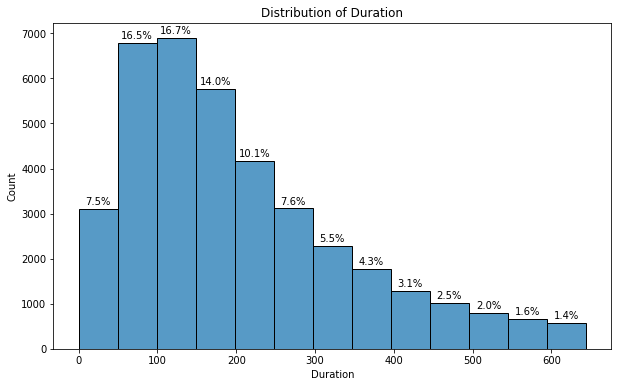

In [60]:
fig=plt.figure(figsize=(10,6))
iqr, upper_bound, lower_bound = get_bound(a)
a2 = a[(a >= lower_bound) & ( a<= upper_bound)]
ax = sns.histplot(a2, bins=13, color=colors[1])
perc=list()
for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    perc.append(label)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height()+100, label, ha='center')
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')

In [61]:
df2[df2.duration<300].shape[0]/df2.shape[0]*100

72.6831163784729

In [62]:
np.median(a),np.median(a2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(180.0, 167.0)

In [63]:
np.mean(a),np.mean(a2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(258.3158150378861, 203.27074555779447)

#### Write up
1. 32% durations of contacts are between 50s-150s.
2. The median of duration is 180s.
3. 73% contacts last less 300s.

### campaign

In [64]:
df2.campaign.describe()

count    41176.000000
mean         2.567879
std          2.770318
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Campaign')

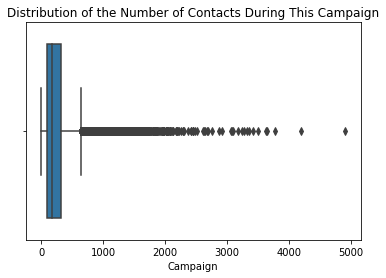

In [65]:
ax = sns.boxplot(x=df2.duration)
plt.title('Distribution of the Number of Contacts During This Campaign')
plt.xlabel('Campaign')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

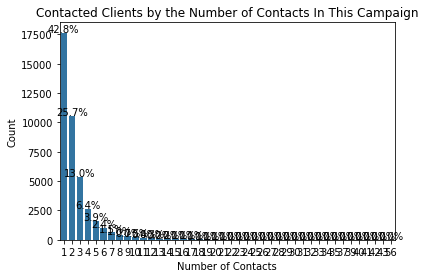

In [66]:
cat_plot('campaign', 'Number of Contacts', 'Contacted Clients by the Number of Contacts In This Campaign',0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2.0 6.0 -2.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

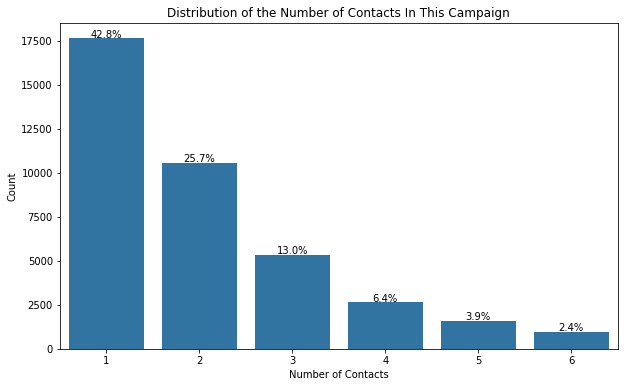

In [67]:
a=df2.campaign
fig=plt.figure(figsize=(10,6))
iqr, upper_bound, lower_bound = get_bound(a)
a2 = a[(a >= lower_bound) & ( a<= upper_bound)]

# get the categories
cat = a2.value_counts().index
# get the counts for the categories
ct= a2.value_counts().values

ax = sns.barplot(x=cat, y=ct, color=colors[1])
for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height()+60, label, ha='center')

plt.title('Distribution of the Number of Contacts In This Campaign')
plt.xlabel('Number of Contacts')
plt.ylabel('Count')

In [68]:
df2[df2.campaign>=6].shape[0]/df2.shape[0]*100

8.220808237808432

#### Write Up
1. 42% clients were contacted once.
2. 8% clients were contacted more than 6 times.
3. The median of the number of contacts is 2.

### Pdays

In [69]:
a = df2.pdays[df2.pdays!=999]
a.describe()

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: pdays, dtype: float64

In [70]:
df2[df2.pdays==999].shape[0]/df2.shape[0]*100

96.32067223625413

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

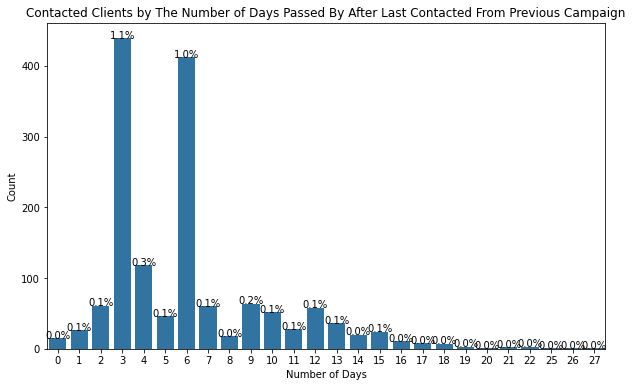

In [71]:
# get the categories
cat = a.value_counts().index
# get the counts for the categories
ct= a.value_counts().values
fig=plt.figure(figsize=(10,6))
ax = sns.barplot(x=cat, y=ct, color=colors[1])
for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')

plt.title('Contacted Clients by The Number of Days Passed By After Last Contacted From Previous Campaign')
plt.xlabel('Number of Days')
plt.ylabel('Count')
# plt.xticks(rotation=rotation)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

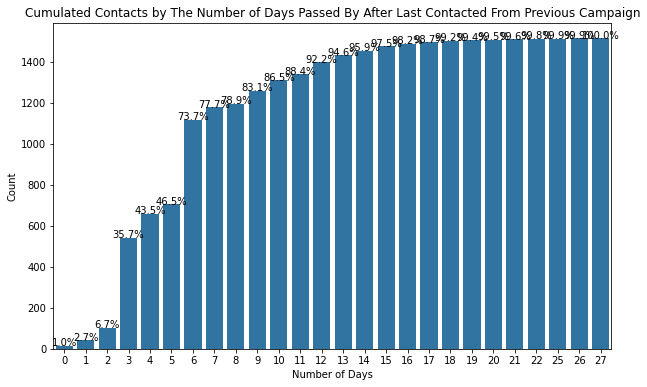

In [72]:
# get the categories
cat = a.value_counts().sort_index().index
# get the counts for the categories
ct = a.value_counts().sort_index().values
ct2= [sum(ct[:i+1]) for i in range(len(ct))]

fig=plt.figure(figsize=(10,6))
ax = sns.barplot(x=cat, y=ct2, color=colors[1])
for patch in ax.patches:
    label = round(patch.get_height()/len(a)*100,1)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')

plt.title('Cumulated Contacts by The Number of Days Passed By After Last Contacted From Previous Campaign')
plt.xlabel('Number of Days')
plt.ylabel('Count')
# plt.xticks(rotation=rotation)

#### Write Up
1. 96% of clients weren't contacted in the previous campaign.
2. Among the 4%, the average days from last contact is 6.
2. Among the 4%, 13% of them were contacted before 10 days, while 7% were contacted within 3 days.
3. Among the 4%, over 75% clients were contacted between 3-10 days ago.

### Previous

In [73]:
df2.previous.describe()

count    41176.000000
mean         0.061104
std          0.360337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

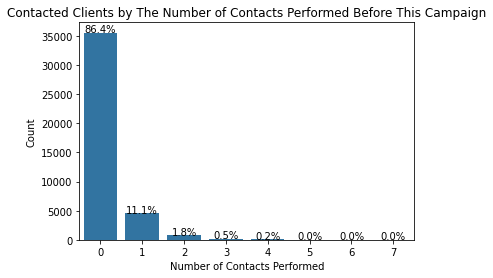

In [74]:
cat_plot('previous', 'Number of Contacts Performed', 'Contacted Clients by The Number of Contacts Performed Before This Campaign',0)

In [75]:
a=df2.previous[df2.previous!=0]
a.describe()

count    1515.000000
mean        1.660726
std         0.934306
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: previous, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

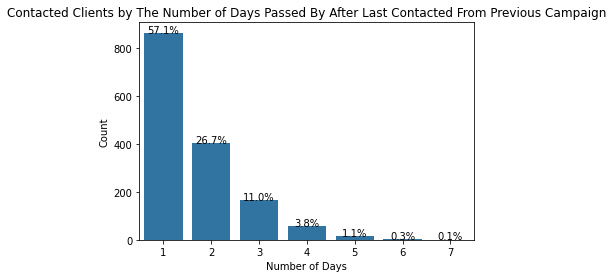

In [76]:
# get the categories
cat = a.value_counts().index
# get the counts for the categories
ct= a.value_counts().values
ax = sns.barplot(x=cat, y=ct, color=colors[1])
for patch in ax.patches:
    label = round(patch.get_height()/len(a)*100,1)
    label = str(label)+'%'
    ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')

plt.title('Contacted Clients by The Number of Days Passed By After Last Contacted From Previous Campaign')
plt.xlabel('Number of Days')
plt.ylabel('Count')
# plt.xticks(rotation=rotation)

#### Write up
1. Average contact times is 0.06.
2. 86% of clients were never contacted.
3. Among the 14% clients, > 50% of them were contacted once, < 2% of them were contacted over 5 times.

### poutcome

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

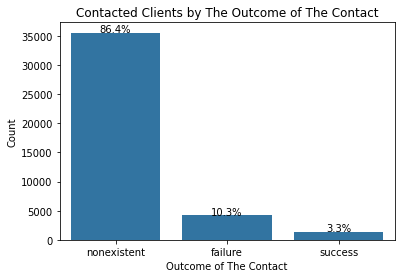

In [77]:
cat_plot('poutcome', 'Outcome of The Contact', 'Contacted Clients by The Outcome of The Contact',0)

#### Write up
1. .> 85% of clients have no outcome.
2. Sucess vs. Failure is 1:3.


### (???) social and economic context

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

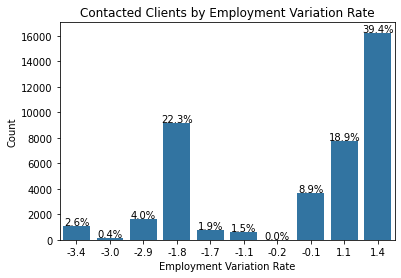

In [78]:
cat_plot('emp.var.rate', 'Employment Variation Rate', 'Contacted Clients by Employment Variation Rate',0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

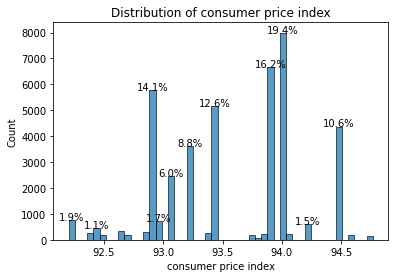

In [79]:
a = df2['cons.price.idx']
ax = sns.histplot(a, color=colors[1])

for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    if label > 1:
        label = str(label)+'%'
        ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')
plt.title('Distribution of consumer price index')
plt.xlabel('consumer price index')
plt.ylabel('Count')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

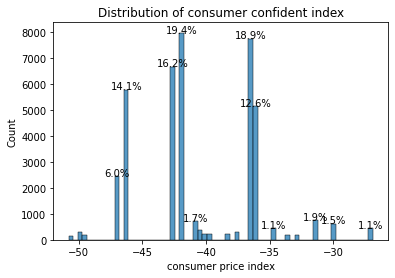

In [80]:
a = df2['cons.conf.idx']
ax = sns.histplot(a, color=colors[1])

for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    if label > 1:
        label = str(label)+'%'
        ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')
plt.title('Distribution of consumer confident index')
plt.xlabel('consumer price index')
plt.ylabel('Count')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Count')

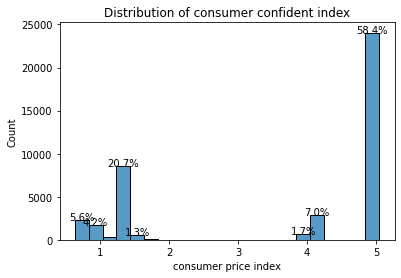

In [81]:
a = df2['euribor3m']
ax = sns.histplot(a, color=colors[1])

for patch in ax.patches:
    label = round(patch.get_height()/df2.shape[0]*100,1)
    if label > 1:
        label = str(label)+'%'
        ax.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')
plt.title('Distribution of consumer confident index')
plt.xlabel('consumer price index')
plt.ylabel('Count')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

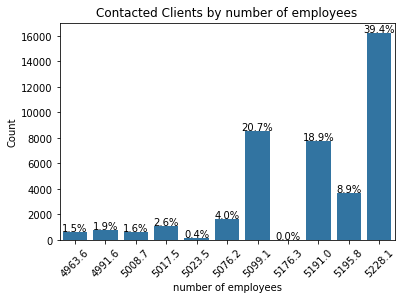

In [82]:
cat_plot('nr.employed', 'number of employees', 'Contacted Clients by number of employees',45)

## Bivariate

In [83]:
target_variable

['y']

### Age

In [132]:
import researchpy as rp 
import scipy.stats as stats
def cat_con(col,title, df=df2,ttest=True):
    title = title.capitalize()
    dfyes = df[df.y=='yes']
    dfno = df[df.y=='no']
    sns.boxplot(y=df[col], x=df.y, data=df)
    plt.title(f'Distribution of {title} by Results of Contacts')
    plt.xlabel('Result of Contacts')
    plt.ylabel(title)

    summary, results = rp.ttest(group1=dfyes[col], group1_name='yes',
              group2=dfno[col], group2_name='no')
    print(summary)
    if ttest==True:
        print()
        print(results)
    else:
        pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N       Mean         SD        SE  95% Conf.   Interval
0       yes   4639.0  40.912266  13.838838  0.203183  40.513930  41.310601
1        no  36537.0  39.910994   9.897176  0.051778  39.809508  40.012481
2  combined  41176.0  40.023800  10.420680  0.051354  39.923145  40.124455

          Independent t-test     results
0   Difference (yes - no) =       1.0013
1      Degrees of freedom =   41174.0000
2                       t =       6.1675
3   Two side test p value =       0.0000
4  Difference < 0 p value =       1.0000
5  Difference > 0 p value =       0.0000
6               Cohen's d =       0.0961
7               Hedge's g =       0.0961
8           Glass's delta =       0.0724
9             Pearson's r =       0.0304


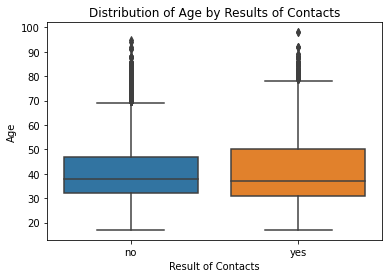

In [134]:
col= 'age'
title = col.capitalize()
cat_con(col,title)

#### Write up
1. Average age of two groups are similar to each other.
2. The group yes has a larger range than the group no.
3. Based on t-test, The average age for group yes is statistically significantly larger than group no, p = 0.001.

#### (details) t-test for age

reference： 
1. https://www.pythonfordatascience.org/independent-samples-t-test-python/
2. https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/7-t-tests

In [135]:
!pip install researchpy

In [136]:
import researchpy as rp 
import scipy.stats as stats

H0: The means of two groups are equal to each other.

Ha: The means of two groups are not equal.

In [137]:
dfyes = df2[df2.y=='yes']
dfno = df2[df2.y=='no']
summary, results = rp.ttest(group1=dfyes.age, group1_name='yes',
          group2=dfno.age, group2_name='no')
print(summary)
print()
print(results)

   Variable        N       Mean         SD        SE  95% Conf.   Interval
0       yes   4639.0  40.912266  13.838838  0.203183  40.513930  41.310601
1        no  36537.0  39.910994   9.897176  0.051778  39.809508  40.012481
2  combined  41176.0  40.023800  10.420680  0.051354  39.923145  40.124455

          Independent t-test     results
0   Difference (yes - no) =       1.0013
1      Degrees of freedom =   41174.0000
2                       t =       6.1675
3   Two side test p value =       0.0000
4  Difference < 0 p value =       1.0000
5  Difference > 0 p value =       0.0000
6               Cohen's d =       0.0961
7               Hedge's g =       0.0961
8           Glass's delta =       0.0724
9             Pearson's r =       0.0304


p-value = 0 < 0.001. Therefore, REJECT null hypothesis.

Interpretation:
The average age for group yes, M = 40.9 (40.5, 41.3), is statistically significantly higher than group no, M = 39.9 (39.8, 40.0); t(41174)=6.1675, p=0.001.

### Job

In [138]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.patches as mpatches

In [139]:
def get_stackedPlot(col,df=df2,rotation=45,title=col,scatter=True):
    crosstable = pd.crosstab(df[col],df['y']).reset_index().sort_values(by='yes',ascending=False)
    crosstable['total'] = crosstable['no']+crosstable['yes']
    crosstable['percs'] = crosstable['yes']/crosstable['total']*100
    crosstable['total_perc'] = 100
    

    fig=plt.figure(figsize=(10,6))
    bar1 = sns.barplot(x=col,y='no', data=crosstable, color=colors[1])
    bar2 = sns.barplot(x=col,y='yes', data=crosstable, color=colors[0])
    for patch in bar1.patches:
        label = round(patch.get_height()/len(a)*100,1)
        label = str(label)+'%'
        bar1.text(patch.get_x()+patch.get_width()/2, patch.get_height(), label, ha='center')

    top_bar = mpatches.Patch(color=colors[1], label='Result = No')
    bottom_bar = mpatches.Patch(color=colors[0], label='Result = Yes')

    plt.legend(handles=[top_bar, bottom_bar])
    plt.title('Contact Result by ' + title +' and Percentage in Total')
    plt.xlabel(title)
    plt.ylabel('Number of Contacts')
    plt.xticks(rotation=rotation)
    plt.show()


    fig=plt.figure(figsize=(10,6))
    crosstable = crosstable.sort_values(by='percs', ascending=False)
    bar1 = sns.barplot(x=col,y='total_perc', data=crosstable, color=colors[1])
    bar2 = sns.barplot(x=col,y='percs', data=crosstable, color=colors[0])
    for patch,perc in zip(bar2.patches,crosstable.percs):
        label = round(perc)
        label = str(label)+'%'
        label2= round(100-perc)
        label2= str(label2)+'%'
        bar2.text(patch.get_x()+patch.get_width()/2, perc/2, label, ha='center')
        bar2.text(patch.get_x()+patch.get_width()/2, perc+(100-perc)/2, label2, ha='center')
    top_bar = mpatches.Patch(color=colors[1], label='Result = No')
    bottom_bar = mpatches.Patch(color=colors[0], label='Result = Yes')
    plt.legend(handles=[top_bar, bottom_bar])
    plt.title(f'Contact Result by {title} in Percentage')
    plt.xlabel(title)
    plt.ylabel('Number of Contacts')
    plt.xticks(rotation=rotation)
    plt.show()

    if scatter is True:
        fig=plt.figure(figsize=(6,6))
        sns.scatterplot(x='percs', y='yes', data = crosstable)
        for i in range(crosstable.shape[0]):
            plt.text(x=crosstable['percs'][i], y=crosstable['yes'][i], s=crosstable[col][i])
        plt.title(f'Counts and Percentage of Subscribing the Term Deposit by {title}')
        plt.ylabel('Amount of Subscribing')
        plt.xlabel('Percentage of Subscribing(%)')
        plt.show()
    else:
        pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

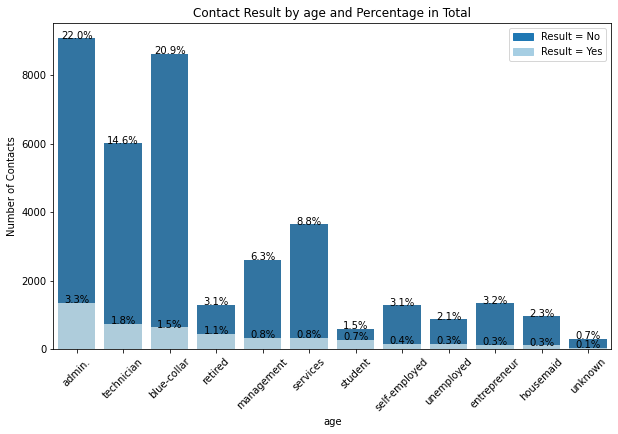

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

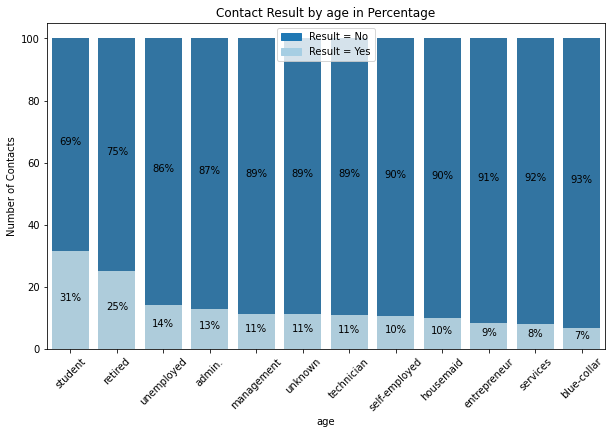

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

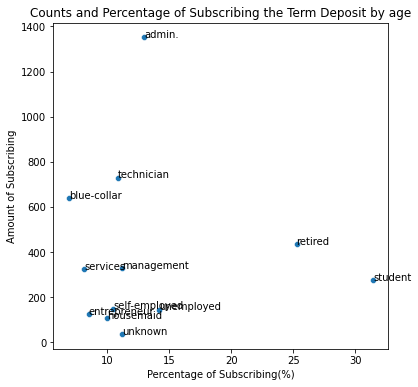

In [140]:
col = 'job'
get_stackedPlot(col)

#### Write up
Stacked plot
1. The yes group mainly work as admin, technician, blue-collar and retired people.

Percentage Stacked plot
1. . > 30% of Students said yes to the campaign.
2. . > 25% of retired people said yes to the campaign.
2. . < 10% of Entrepreneur, services, or blue-collar said yes.

Scatter Plot
yes rate - amount
1. Student and retired people have high rate and moderate low mount
2. Admin has moderate low rate and high amount
3. Technician have moderate low rate - moderate amount.

#### (ignore) other exploration 

In [141]:
major_job=['admin.', 'blue-collar', 'technician', 'services'] 
'admin.' in major_job

True

In [142]:
major_job=['admin.', 'blue-collar', 'technician', 'services'] 
df2['major_job'] =['major' if x in major_job  else 'minor' for x in df2.job]
crosstable = pd.crosstab(df2['major_job'],df2['y']).reset_index().sort_values(by='no',ascending=False)
crosstable['total'] = crosstable['no']+crosstable['yes']
crosstable['perc'] = crosstable['yes']/crosstable['total']*100
crosstable['total_perc'] = 100
crosstable

<IPython.core.display.Javascript object>

y,major_job,no,yes,total,perc,total_perc
0,major,27336,3042,30378,10.013826,100
1,minor,9201,1597,10798,14.789776,100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

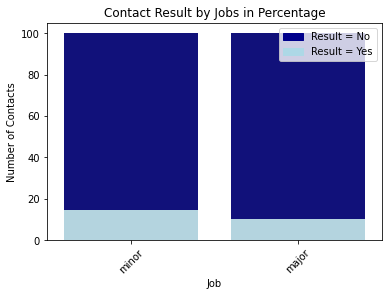

In [143]:
crosstable = crosstable.sort_values(by='perc', ascending=False)
bar1 = sns.barplot(x='major_job',y='total_perc', data=crosstable, color='darkblue')
bar2 = sns.barplot(x='major_job',y='perc', data=crosstable, color='lightblue')
top_bar = mpatches.Patch(color='darkblue', label='Result = No')
bottom_bar = mpatches.Patch(color='lightblue', label='Result = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Contact Result by Jobs in Percentage')
plt.xlabel('Job')
plt.ylabel('Number of Contacts')
plt.xticks(rotation=45)
plt.show()

### Marital

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

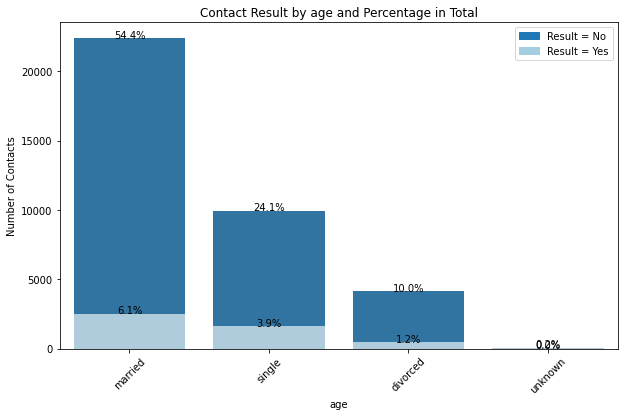

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

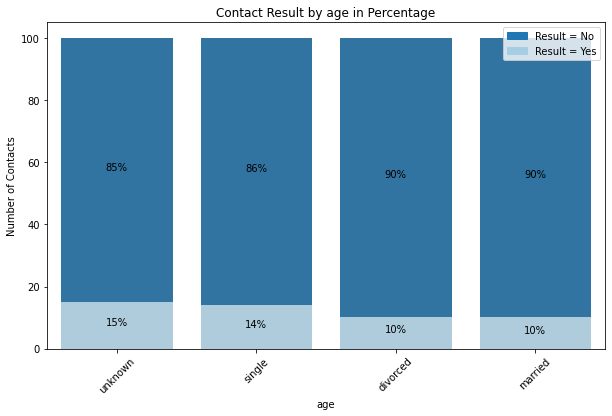

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

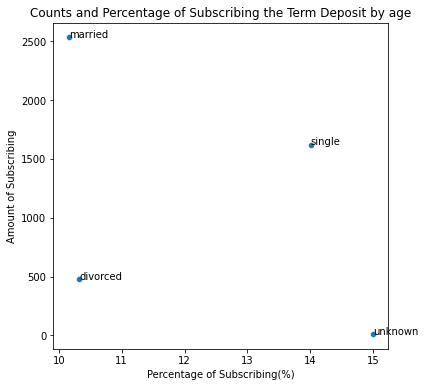

In [144]:
col = 'marital'
get_stackedPlot(col)

#### Write up
Stacked plot
1. . > 6% of clients are married and said yes.

Percentage Stacked plot
1. . > 14% of Unknown and Single people said yes.

Scatter Plot
yes rate - amount
1. Single people have high rate and moderate high mount.
2. Married people have low rate but high amount.
3. Unknown people have high rate but low amount.

### Education

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

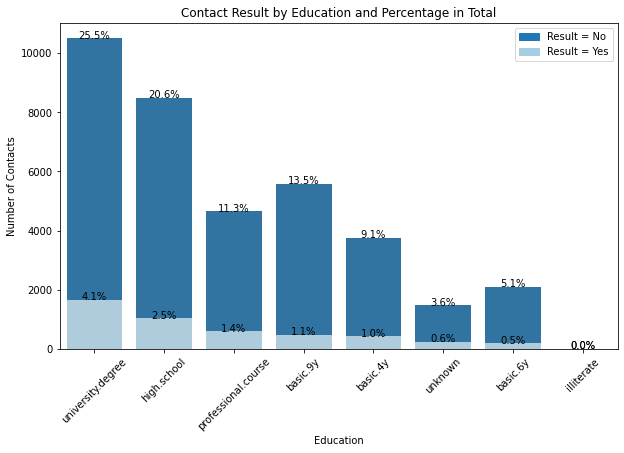

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

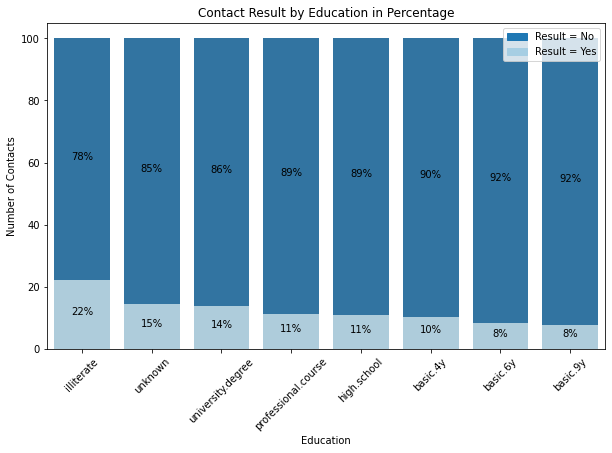

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

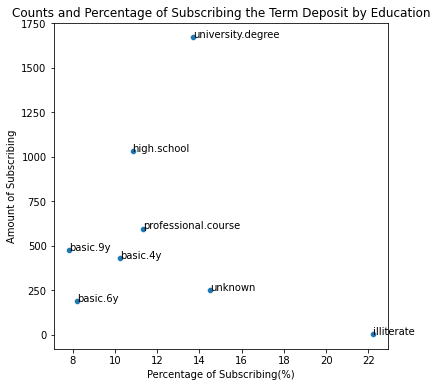

In [145]:
get_stackedPlot('education', title='Education')

### Default

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

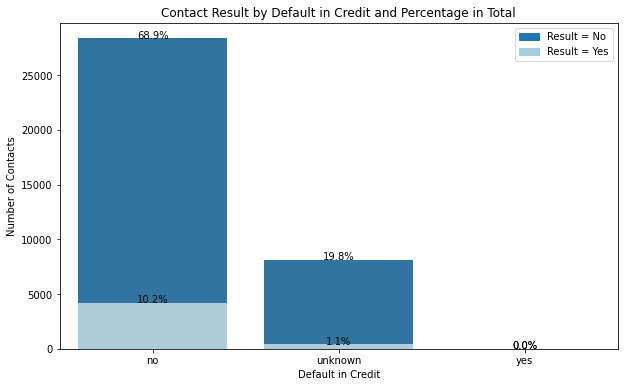

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

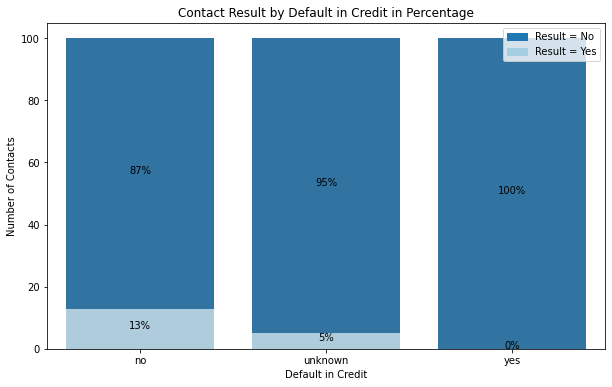

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

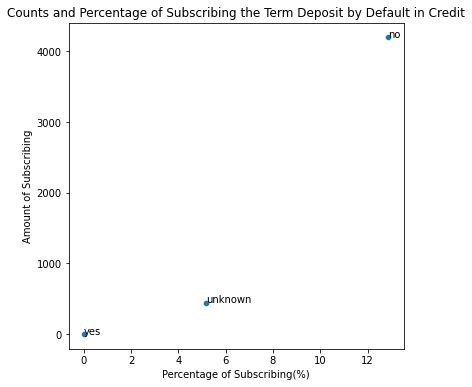

In [146]:
get_stackedPlot('default', title='Default in Credit', rotation=0)

### Housing

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

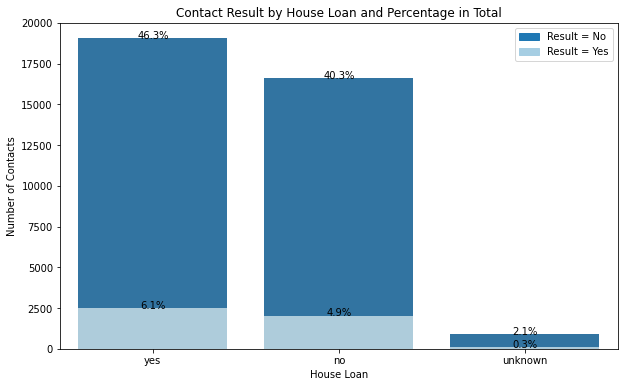

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

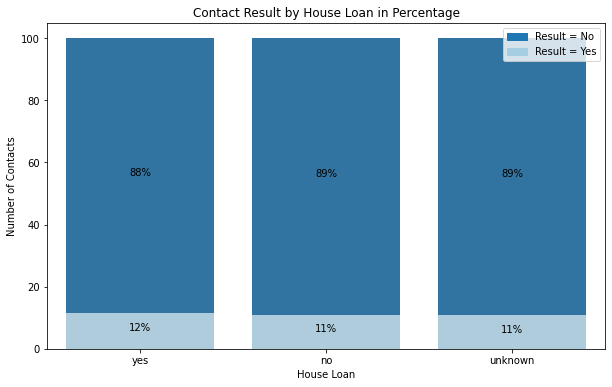

In [147]:
get_stackedPlot('housing',title='House Loan', rotation=0, scatter=False)

### Loan

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

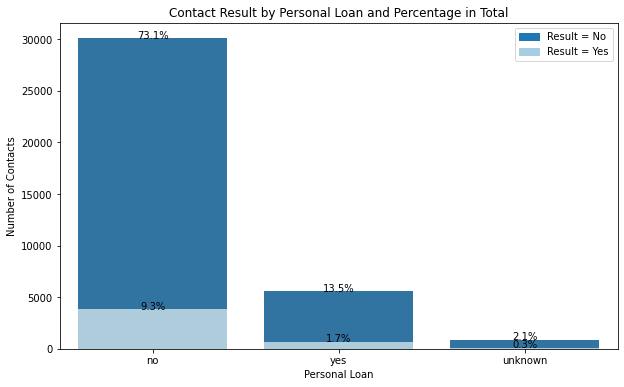

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

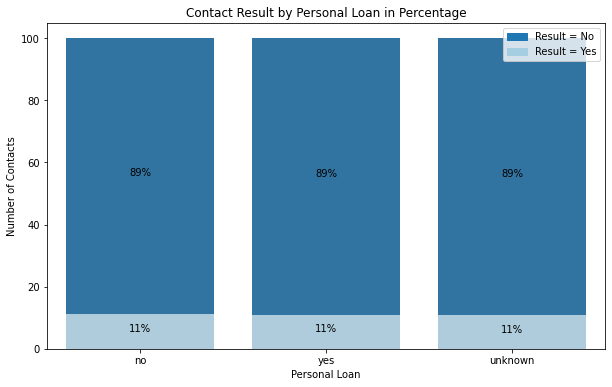

In [148]:
get_stackedPlot('loan',title='Personal Loan', rotation=0, scatter=False)

### Contact

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

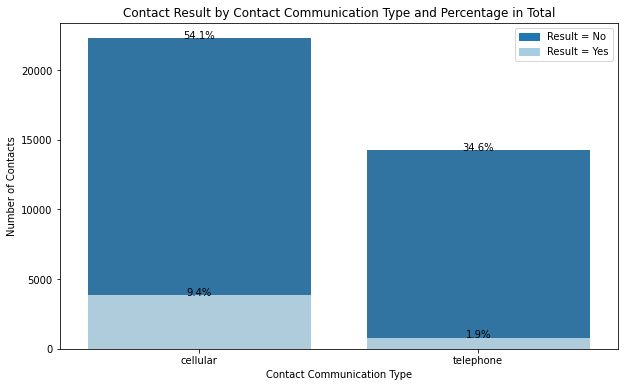

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

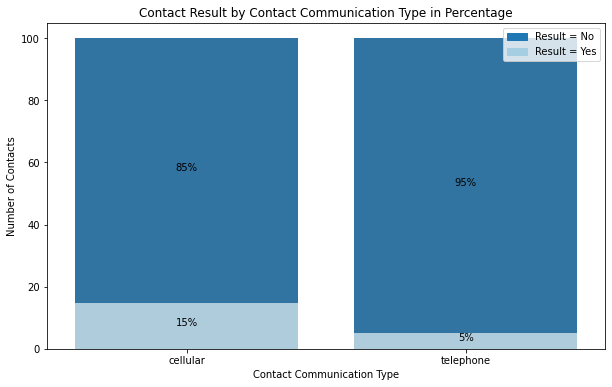

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

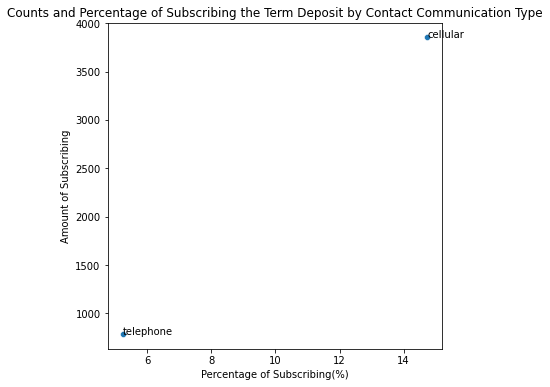

In [149]:
get_stackedPlot('contact', title = 'Contact Communication Type', rotation=0)

### Month

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

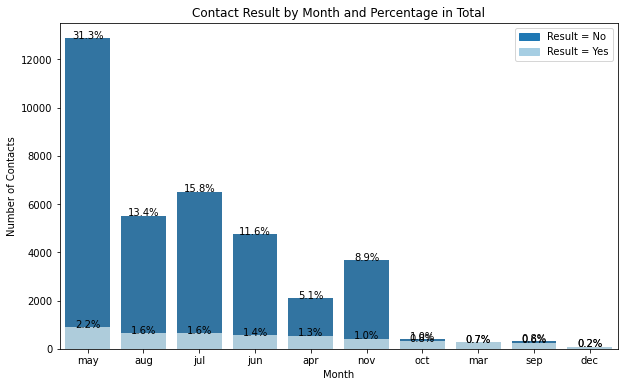

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

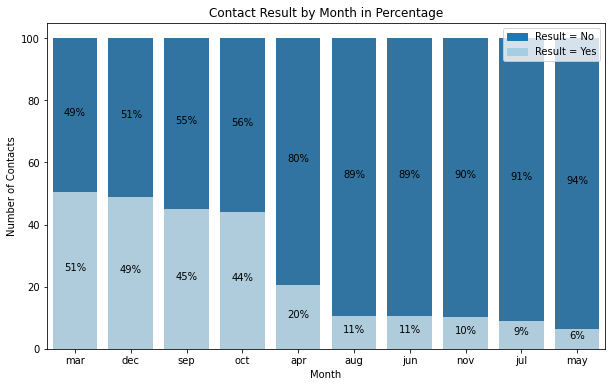

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

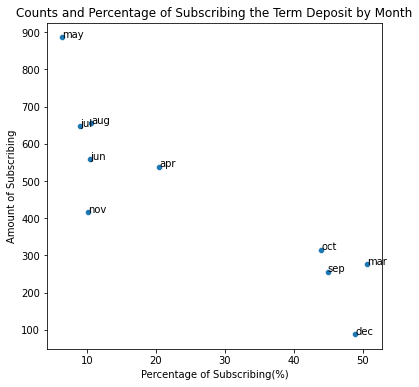

In [150]:
get_stackedPlot('month', title='Month', rotation=0)

#### Write up ?


### Day of Week

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

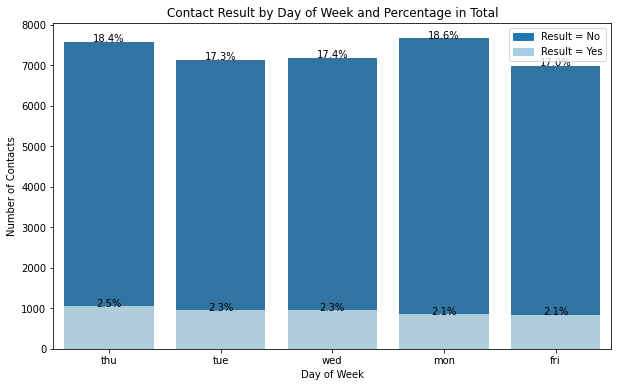

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

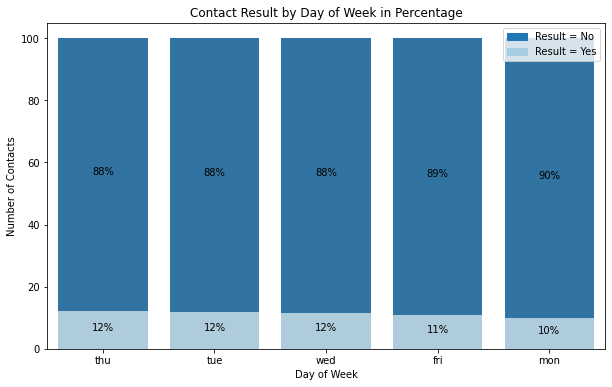

In [151]:
get_stackedPlot('day_of_week',title='Day of Week', rotation=0, scatter=False) 

#### Write up
The % of saying yes are similar.

### duration

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N        Mean          SD        SE   95% Conf.    Interval
0       yes   4639.0  553.256090  401.190736  5.890318  541.708266  564.803914
1        no  36537.0  220.868079  207.116178  1.083547  218.744296  222.991862
2  combined  41176.0  258.315815  259.305321  1.277878  255.811147  260.820483

          Independent t-test     results
0   Difference (yes - no) =     332.3880
1      Degrees of freedom =   41174.0000
2                       t =      89.9603
3   Two side test p value =       0.0000
4  Difference < 0 p value =       1.0000
5  Difference > 0 p value =       0.0000
6               Cohen's d =       1.4022
7               Hedge's g =       1.4021
8           Glass's delta =       0.8285
9             Pearson's r =       0.4053


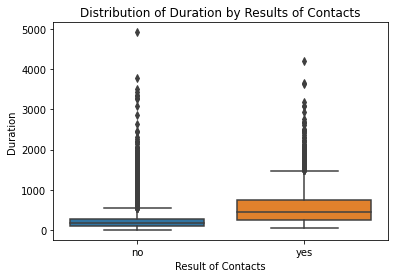

In [152]:
col = 'duration'
title = col.capitalize()
cat_con(col,title)

#### Write up
1. The average duration for group yes is significately longer than group no.

### Campaign

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0       yes   4639.0  2.051951  1.666353  0.024466   2.003987  2.099915
1        no  36537.0  2.633385  2.873768  0.015034   2.603918  2.662853
2  combined  41176.0  2.567879  2.770318  0.013652   2.541120  2.594638

          Independent t-test     results
0   Difference (yes - no) =      -0.5814
1      Degrees of freedom =   41174.0000
2                       t =     -13.4952
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -0.2103
7               Hedge's g =      -0.2103
8           Glass's delta =      -0.3489
9             Pearson's r =       0.0664


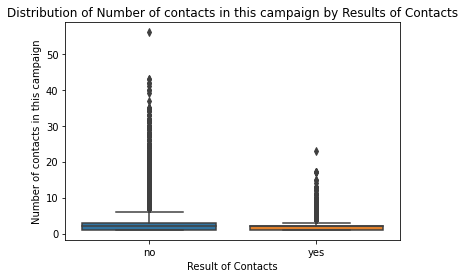

In [153]:
col='campaign'
title = 'Number of Contacts in This Campaign'
cat_con(col,title)

### pdays

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       yes   967.0  5.913133  3.727896  0.119881   5.677876  6.148391
1        no   548.0  6.193431  3.987525  0.170339   5.858833  6.528029
2  combined  1515.0  6.014521  3.824906  0.098269   5.821765  6.207278


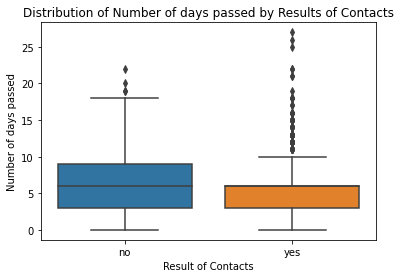

In [154]:
col='pdays'
title = 'Number of Days Passed'
cat_con(col,title=title, df=df2[df2.pdays!=999], ttest=False)

### previous

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       yes   967.0  1.714581  0.944212  0.030364   1.654995  1.774168
1        no   548.0  1.565693  0.909663  0.038859   1.489363  1.642024
2  combined  1515.0  1.660726  0.934306  0.024004   1.613642  1.707811


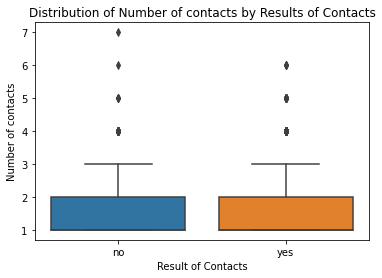

In [155]:
col='previous'
title = 'Number of Contacts'
cat_con(col, title=title, df=df2[df2.previous!=0],ttest=False)

### Poutcome

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

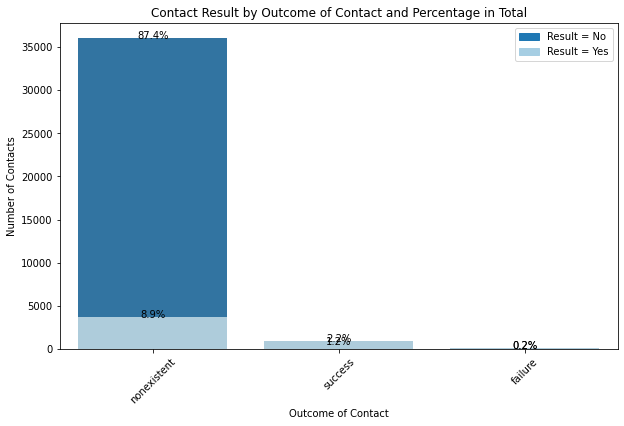

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

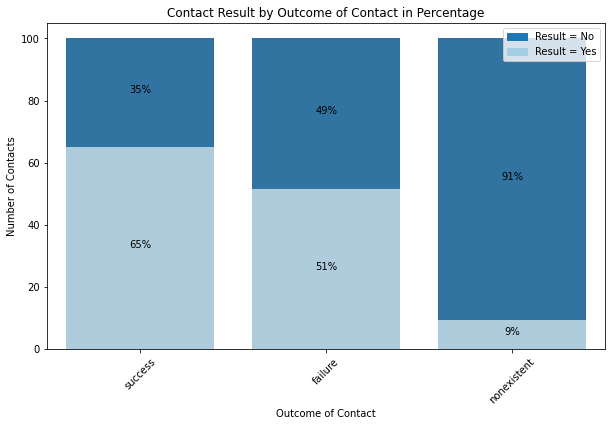

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

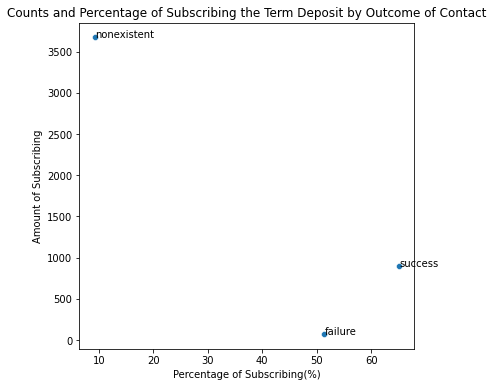

In [156]:
get_stackedPlot('poutcome',title='Outcome of Contact')

### social and economic context

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0       yes   4639.0 -1.233089  1.623616  0.023838  -1.279823 -1.186355
1        no  36537.0  0.248885  1.482873  0.007758   0.233679  0.264090
2  combined  41176.0  0.081922  1.570883  0.007741   0.066748  0.097095

          Independent t-test     results
0   Difference (yes - no) =      -1.4820
1      Degrees of freedom =   41174.0000
2                       t =     -63.4137
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -0.9884
7               Hedge's g =      -0.9884
8           Glass's delta =      -0.9128
9             Pearson's r =       0.2983


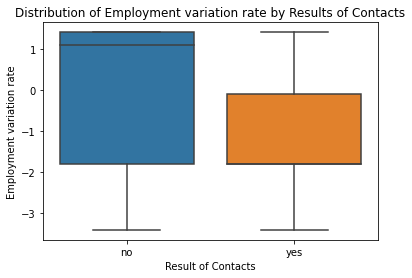

In [165]:
cat_con('emp.var.rate',title='Employment Variation Rate')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N       Mean        SD        SE  95% Conf.   Interval
0       yes   4639.0  93.354577  0.676592  0.009934  93.335102  93.374052
1        no  36537.0  93.603798  0.559006  0.002924  93.598066  93.609530
2  combined  41176.0  93.575720  0.578839  0.002853  93.570129  93.581311

          Independent t-test     results
0   Difference (yes - no) =      -0.2492
1      Degrees of freedom =   41174.0000
2                       t =     -27.8830
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -0.4346
7               Hedge's g =      -0.4346
8           Glass's delta =      -0.3683
9             Pearson's r =       0.1361


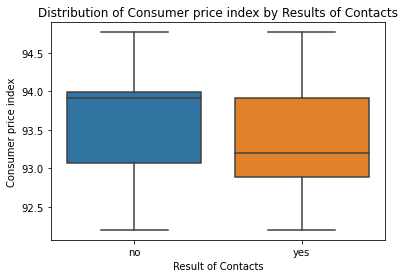

In [166]:
cat_con('cons.price.idx',title='consumer price index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N       Mean        SD        SE  95% Conf.   Interval
0       yes   4639.0 -39.791119  6.139657  0.090143 -39.967842 -39.614396
1        no  36537.0 -40.593232  4.390759  0.022971 -40.638255 -40.548208
2  combined  41176.0 -40.502863  4.627860  0.022806 -40.547564 -40.458162

          Independent t-test     results
0   Difference (yes - no) =       0.8021
1      Degrees of freedom =   41174.0000
2                       t =      11.1368
3   Two side test p value =       0.0000
4  Difference < 0 p value =       1.0000
5  Difference > 0 p value =       0.0000
6               Cohen's d =       0.1736
7               Hedge's g =       0.1736
8           Glass's delta =       0.1306
9             Pearson's r =       0.0548


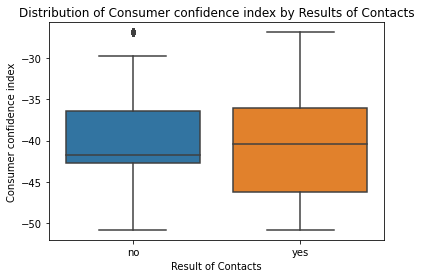

In [167]:
cat_con('cons.conf.idx',title='consumer confidence index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0       yes   4639.0  2.123362  1.742717  0.025587   2.073200  2.173524
1        no  36537.0  3.811482  1.638179  0.008570   3.794684  3.828280
2  combined  41176.0  3.621293  1.734437  0.008547   3.604540  3.638047

          Independent t-test     results
0   Difference (yes - no) =      -1.6881
1      Degrees of freedom =   41174.0000
2                       t =     -65.6298
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -1.0229
7               Hedge's g =      -1.0229
8           Glass's delta =      -0.9687
9             Pearson's r =       0.3077


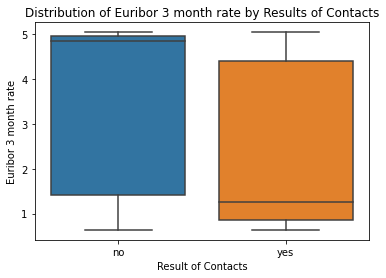

In [168]:
cat_con('euribor3m',title='euribor 3 month rate')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   Variable        N         Mean  ...        SE    95% Conf.     Interval
0       yes   4639.0  5095.120069  ...  1.285881  5092.599130  5097.641008
1        no  36537.0  5176.165690  ...  0.337805  5175.503582  5176.827797
2  combined  41176.0  5167.034870  ...  0.356061  5166.336983  5167.732756

[3 rows x 7 columns]

          Independent t-test     results
0   Difference (yes - no) =     -81.0456
1      Degrees of freedom =   41174.0000
2                       t =     -76.9710
3   Two side test p value =       0.0000
4  Difference < 0 p value =       0.0000
5  Difference > 0 p value =       1.0000
6               Cohen's d =      -1.1997
7               Hedge's g =      -1.1997
8           Glass's delta =      -0.9254
9             Pearson's r =       0.3547


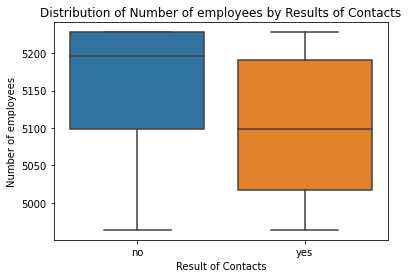

In [169]:
cat_con('nr.employed',title='number of employees')